In [1]:

from IPython.display import Image
from IPython.display import HTML, Markdown
import math
import numpy, pandas 
import matplotlib.pyplot as plt
import openpyxl
import xlrd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy import __version__
from os.path import join
from os import listdir
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
import scipy.constants as constants
from sys import float_info

print('finished import')


finished import


In [ ]:
#To convert raw deposition data into normalised absorbance, background substracted, with 3 gaussian fit

#define folder tructure

export_path='data/exports'
path = 'data/raw_depositions'

temperatures = listdir(path)
temperatures.sort()
all_temp_mix=temperatures
all_temp = [int(temp[:-1]) for temp in all_temp_mix] #remove 'K' from the end of each temp and turn into integers

#Use a dictionary to store details on fits for each 

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_dict = nested_dict(3, int)
    
#find all of the raw data
temperatures = [t for t in temperatures if not t.endswith('.csv')]
column_names = ['Lambda','Keith/nA','Ch1/volts','Ch2/volts','Ch3/volts','Z_Motor','Beam_current','temperature','GC_Pres','Time','UBX_x','UBX_y']

#Start rolling through the data
datasets = pd.DataFrame()

for temperatures in temperatures:
    
    #continue to plow through the files:
    temperature_deposition = join(path, temperatures)
    #print(temperature_deposition)
    data_files = listdir(temperature_deposition)
    data_files.sort()
       
    #Identify the background file at this deposition temperature. NOTE this assumes that we average over two scans, add more if required.
    BkGd1 = data_files[0]
    BkGd2 = data_files[1]
    
    #take an average of the two background readings as I0
    average_BkGd =pd.DataFrame()
    Background1 = pd.read_csv(join(temperature_deposition, BkGd1),header=[15],delimiter=r"\s+")
    Background2 = pd.read_csv(join(temperature_deposition, BkGd2),header=[15],delimiter=r"\s+")
    Background1.columns = column_names
    Background1['nor_signal'] = ((180/Background1['Beam_current'])*Background1['Keith/nA'])
    Background2.columns = column_names
    Background2['nor_signal'] = ((180/Background2['Beam_current'])*Background2['Keith/nA'])
    average_BkGd['wavelength'] = (Background1['Lambda'])
    average_BkGd['av_BkGd_signal'] = (Background1['nor_signal']+Background2['nor_signal'])/2
    
    #define some arrays to use for averaging
    i = 0
    count=1
    my_list=[]
    
    current_abs = average_BkGd['av_BkGd_signal']
            
    for df in data_files:
               
        name=df[:-5]
        deposition=df[-6:-5]     
                
        #For all files that are not background:
        if(int(deposition)>0):
            #print(name)
            #print(deposition)
                                                
            #read the data file            
            raw = pd.read_csv(join(temperature_deposition, df),header=[15],delimiter=r"\s+")
            raw.columns = column_names
            raw['nor_signal'] = ((180/raw['Beam_current'])*raw['Keith/nA'])
                       
            
            #average the absorbance signal over the number of scans for a given deposition
            if(int(i) == int(deposition)):                             
                count=count+1
                #print('I am averaging over '+str(count)+' scans')
                average_signal = (raw['nor_signal']+nor_signal)/count 
                
                df = pd.DataFrame()
                df['wavelength'] = (average_BkGd['wavelength'])  
                df['absorbance'] = np.log10(average_BkGd['av_BkGd_signal']/average_signal, where= (average_BkGd['av_BkGd_signal']/average_signal) > 0)
                          
                #remove wavelengths with too low absorbance to measure - decide this is below 117 nm
                index = df.index[df['wavelength'] == 117.0][0]
                df = df.iloc[index:]
                df = df.reset_index(drop=True)
                df = df[df['wavelength'] <= 180]
            
                # attempt to fit with three Gaussians
                #set a linear background by finding the minimum point on the curve and drawing a linear line here
                linear_BkGd=df['absorbance'].min()
                #now substract thebackground from the data
                df['absorbance_bk'] = df['absorbance'] - linear_BkGd  
                #make shorthand for wavelength
                wl =  df['wavelength']
            
                #define the Gaussians:
                def _1gaussian(wl,amp1,cen1,sigma1):
                    return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))))
            
                def _2gaussian(wl,amp1,cen1,sigma1,amp2,cen2,sigma2):
                    return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))) + \
                            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen2)/sigma2)**2))))
           
                def _3gaussian(wl,amp1,cen1,sigma1,amp2,cen2,sigma2, amp3, cen3, sigma3):
                     return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen1)/sigma1)**2))) + \
                             amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen2)/sigma2)**2))) + \
                             amp3*(1/(sigma3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl-cen3)/sigma3)**2))))
            
                #set limits for fitting; amp1,position1, width1,amp2,position2, width2,amp3,position3, width3.
                bounds_min = [0.05,145,0, 0,120,0 ,0,96.5,12.4]
                bounds_max = [100,150,15, 25,130,10, 50,97,12.6]    
                init_vals=[10, 150, 6, 20, 123, 10, 10, 96.8, 12.5] 
            
                #run fit
                popt_3gauss, pcov_3gauss = curve_fit(_3gaussian, wl, df['absorbance_bk'], p0=init_vals, bounds=(bounds_min,bounds_max)
                                        )
                #calculate errors and residuals:
                perr_3gauss = np.sqrt(np.diag(pcov_3gauss)) # calculate the err on the fit
                df['residual_3gauss'] = df['absorbance_bk'] - (_3gaussian(df['wavelength'], *popt_3gauss)) # make a function to subtract the fit from the data called residuals     
                df['_3Gauss_fit'] = _3gaussian(df['wavelength'], *popt_3gauss)
                residuals=sum((df['absorbance_bk']-(_3gaussian(df['wavelength'], *popt_3gauss)))**2)
                
                #extract fit parameters:
                pars_1 = popt_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
                pars_2 = popt_3gauss[3:6]
                pars_3 = popt_3gauss[6:9]
                                                
                pars_err_1 = perr_3gauss[0:3] # divide the output parameteres into to arrays, one for the first Gaussian; a 2nd for Gaussian 2; etc
                pars_err_2 = perr_3gauss[3:6]
                pars_err_3 = perr_3gauss[6:9]
                
                #Put all fits into the dictionary called 'data_dict'
                Gauss_1 = np.concatenate((pars_1, pars_err_1))
                Gauss_2 = np.concatenate((pars_2, pars_err_2))
                Gauss_3 = np.concatenate((pars_3, pars_err_3))
                
                Gaussian_peaks_list = [Gauss_1,Gauss_2,Gauss_3]
                iterate=['Gauss_1','Gauss_2','Gauss_3']
                start=0
                
                for Gauss in iterate:   
                    data_dict[temperatures][deposition][Gauss] +=  (Gaussian_peaks_list[start])
                    start=start+1
                
                #append fits to the df:
                df['gauss_peak_1'] = _1gaussian(df['wavelength'], *pars_1)
                df['gauss_peak_2'] = _1gaussian(df['wavelength'], *pars_2)
                df['gauss_peak_3'] = _1gaussian(df['wavelength'], *pars_3)
                df['residuals_sum'] = residuals
            
                #show the dataframe
                #print(df.head()) 
                       
                #plot each fit, file by file
                fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}) # I am making a 2 x 1 row x column grid, when the first row is 3 times the height ofthe2nd
                fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
    
                fig.suptitle('fit data with 3 Gaussians'+name, family="serif", fontsize=12)
                plt.xlabel('wavelength / nm', family="serif", fontsize=12)
                axs[1].plot(wl,df['residual_3gauss'],'go:',label='res')
                axs[1].legend() 
                axs[1].set_ylabel("residuals",family="serif", fontsize=12)  
                axs[0].plot(wl,df['absorbance_bk'],'b+:',label='data')
                axs[0].plot(wl,df['_3Gauss_fit'],'r:',label='fit')
                axs[0].legend()
                axs[0].plot(wl, df['gauss_peak_1'], "g")
                axs[0].fill_between(wl, df['gauss_peak_1'].min(), df['gauss_peak_1'], facecolor="green", alpha=0.5)
                axs[0].set_ylabel("absorbance",family="serif", fontsize=12)    
                axs[0].plot(wl, df['gauss_peak_2'], "y")
                axs[0].fill_between(wl, df['gauss_peak_2'].min(), df['gauss_peak_2'], facecolor="yellow", alpha=0.5)  
                axs[0].plot(wl, df['gauss_peak_3'], "m")
                axs[0].fill_between(wl, df['gauss_peak_3'].min(), df['gauss_peak_3'], facecolor="magenta", alpha=0.5)  
                axs[0].annotate(residuals, xy =(150, 0.3))
                plt.show() #This command would plot a different graph for each f during the cycling
   
                #Save the dataframe to csv file
                os.chdir(export_path)
                df.to_csv(name+'.csv', index=False)
                os.chdir('..')
                os.chdir('..') 
                       
            else:
                 #see where we are for averaging
                i = deposition
                count=1
                nor_signal = raw['nor_signal'].to_numpy()
                #Make a list to know which deposition we are on:
                my_list.append(i)
                #print(my_list)
                


#check that all works OK.
#print(data_dict)
#NOTE data_dict[temperatures][deposition][Gauss][amplitude,position,width,amp_err,position_err,width_err]

#plot example for peak labelling
Temp_to_plot = ('50K') #e.g., 100K (no space!)
Dep_to_plot = ('3') #e.g., '2' just number

File_name = ('MeOH_'+(Temp_to_plot)+'_Dep'+(Dep_to_plot))

os.chdir(export_path)
file_to_plot = pd.read_csv(File_name+'.csv',header=[0])

os.chdir('..')
os.chdir('..')

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}) # I am making a 2 x 1 row x column grid, when the first row is 3 times the height ofthe2nd
fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
    
fig.suptitle('3 Gaussian fit for '+File_name, family="garamond", fontsize=22)
plt.xlabel('wavelength / nm', family="garamond", fontsize=18)
axs[1].plot(file_to_plot['wavelength'],file_to_plot['residual_3gauss'],'go:',label='res')
axs[1].legend() 
axs[1].set_ylabel("residuals",family="garamond", fontsize=18)  
axs[0].plot(file_to_plot['wavelength'],file_to_plot['absorbance_bk'],'b+:',label='data')
axs[0].plot(file_to_plot['wavelength'],file_to_plot['_3Gauss_fit'],'r:',label='fit')
axs[0].legend()
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_1'], "g")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_1'].min(), file_to_plot['gauss_peak_1'], facecolor="green", alpha=0.5)
axs[0].set_ylabel("absorbance",family="garamond", fontsize=18)    
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_2'], "y")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_2'].min(), file_to_plot['gauss_peak_2'], facecolor="yellow", alpha=0.5)  
axs[0].plot(file_to_plot['wavelength'], file_to_plot['gauss_peak_3'], "m")
axs[0].fill_between(file_to_plot['wavelength'], file_to_plot['gauss_peak_3'].min(), file_to_plot['gauss_peak_3'], facecolor="magenta", alpha=0.5)  

axs[0].annotate('G1', xy =(145, 0.1))
axs[0].annotate('G2', xy = (125,0.2))
axs[0].annotate('G3', xy = (120, 0.1))
                
plt.show()

            
            

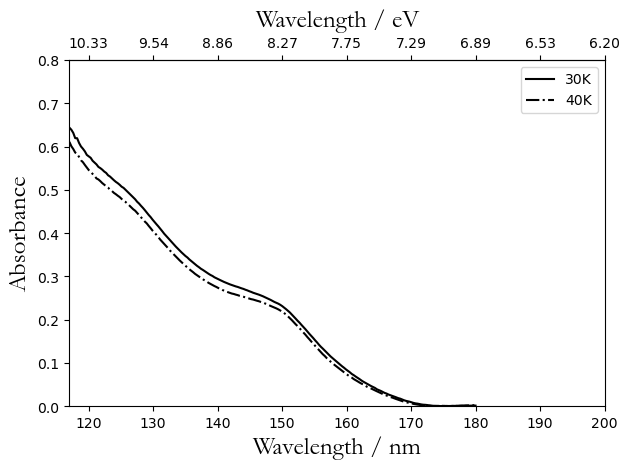

In [10]:
#plot selected spectra
Temp_to_plot = ('30K','40K') #e.g., 100K (no space!) You can plot two different temperatures
Dep_to_plot = ('3') #e.g., '2' just number

File_name1 = ('MeOH_'+(Temp_to_plot[0])+'_Dep'+(Dep_to_plot))
File_name2 = ('MeOH_'+(Temp_to_plot[1])+'_Dep'+(Dep_to_plot))

os.chdir(export_path)
file1_to_plot = pd.read_csv(File_name1+'.csv',header=[0])#,delimiter=r"\s+")
file2_to_plot = pd.read_csv(File_name2+'.csv',header=[0])#,delimiter=r"\s+")

os.chdir('..')
os.chdir('..')

# Function to prevent zero values in an array
def preventDivisionByZero(some_array):
    corrected_array = some_array.copy()
    for i, entry in enumerate(some_array):
        # If element is zero, set to some small value
        if abs(entry) < float_info.epsilon:
            corrected_array[i] = float_info.epsilon
    
    return corrected_array

# Converting wavelength (nm) to energy (eV)
def WLtoE(wl):
    # Prevent division by zero error
    wl = preventDivisionByZero(wl)

    # E = h*c/wl            
    h = constants.h         # Planck constant
    c = constants.c         # Speed of light
    J_eV = constants.e      # Joule-electronvolt relationship
    
    wl_nm = wl * 10**(-9)   # convert wl from nm to m
    E_J = (h*c) / wl_nm     # energy in units of J
    E_eV = E_J / J_eV       # energy in units of eV
    
    return E_eV  

# Converting energy (eV) to wavelength (nm)
def EtoWL(E):
    # Prevent division by zero error
    E = preventDivisionByZero(E)
    
    # Calculates the wavelength in nm
    return constants.h * constants.c / (constants.e * E) * 10**9

fig, ax1 = plt.subplots()

ax1.plot(file1_to_plot['wavelength'], file1_to_plot['absorbance_bk'],'k-', label=(Temp_to_plot[0]))
ax1.plot(file2_to_plot['wavelength'], file2_to_plot['absorbance_bk'], 'k-.', label=(Temp_to_plot[1]))

ax1.set_ylabel('Absorbance',family="garamond", fontsize=18)
ax1.set_xlabel('Wavelength / nm',family="garamond", fontsize=18)
plt.ylim(0,0.8)
ax1.set_xlim(117,200)

# Create the second x-axis on which the energy in eV will be displayed
ax2 = ax1.secondary_xaxis('top', functions=(WLtoE, EtoWL))
ax2.set_xlabel('Wavelength / eV',family="garamond", fontsize=18, labelpad=7)

# Get ticks from ax1 (wavelengths)
wl_ticks = ax1.get_xticks()
wl_ticks = preventDivisionByZero(wl_ticks)

# Based on the ticks from ax1 (wavelengths), calculate the corresponding energies in eV
E_ticks = WLtoE(wl_ticks)

# Set the ticks for ax2 (Energy)
ax2.set_xticks(E_ticks)

# Allow for two decimal places on ax2 (Energy)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


ax1.legend()
plt.tight_layout()
plt.show()

    



In [68]:
#choose a deposition to extract and compare peak positions
deposition_to_use=('3')
which_Gauss_top=('Gauss_2')
which_Gauss_bottom=('Gauss_1')

Gauss_top_pos = [data_dict['100K'][deposition_to_use][which_Gauss_top][1],
               data_dict['105K'][deposition_to_use][which_Gauss_top][1],
               data_dict['110K'][deposition_to_use][which_Gauss_top][1],
               data_dict['112K'][deposition_to_use][which_Gauss_top][1],
               data_dict['115K'][deposition_to_use][which_Gauss_top][1],
               data_dict['120K'][deposition_to_use][which_Gauss_top][1],
               data_dict['20K'][deposition_to_use][which_Gauss_top][1],
               data_dict['30K'][deposition_to_use][which_Gauss_top][1],
               data_dict['40K'][deposition_to_use][which_Gauss_top][1],
               data_dict['50K'][deposition_to_use][which_Gauss_top][1],
               data_dict['60K'][deposition_to_use][which_Gauss_top][1],
               data_dict['70K'][deposition_to_use][which_Gauss_top][1],
               data_dict['80K'][deposition_to_use][which_Gauss_top][1],
               data_dict['90K'][deposition_to_use][which_Gauss_top][1]]

Gauss_top_pos_err = [data_dict['100K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['105K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['110K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['112K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['115K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['120K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['20K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['30K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['40K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['50K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['60K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['70K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['80K'][deposition_to_use][which_Gauss_top][4],
                   data_dict['90K'][deposition_to_use][which_Gauss_top][4]]

Gauss_bottom_pos = [data_dict['100K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['105K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['110K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['112K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['115K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['120K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['20K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['30K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['40K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['50K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['60K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['70K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['80K'][deposition_to_use][which_Gauss_bottom][1],
               data_dict['90K'][deposition_to_use][which_Gauss_bottom][1]]

Gauss_bottom_pos_err = [data_dict['100K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['105K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['110K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['112K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['115K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['120K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['20K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['30K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['40K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['50K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['60K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['70K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['80K'][deposition_to_use][which_Gauss_bottom][4],
                   data_dict['90K'][deposition_to_use][which_Gauss_bottom][4]]

print(Gauss_top_pos_err)

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,1]}) # I am making a 2 x 1 row x column grid
fig.subplots_adjust(hspace=0.1)
plt.xlabel('temperature / K', family="garamond", fontsize=18)
fig.suptitle('deposition '+str(deposition_to_use), family="garamond", fontsize=22)

#ax.errorbar(x, z, markersize=10, xerr=sigx, yerr=sigy, fmt='.', color='red', label='observed')
axs[0].errorbar(all_temp, Gauss_top_pos, yerr=None, xerr = Gauss_top_pos_err, 'bo', label='Peak 1')
axs[0].set_ylabel(str(which_Gauss_top)+" / nm",family="garamond", fontsize=18)   
axs[0].minorticks_on()

axs[1].plot(all_temp, Gauss_bottom_pos, 'go', label='Peak 2')
#axs[1].axhline(y=allPeak2[1], linewidth=0.7, color='k', ls='--')
axs[1].set_ylabel(str(which_Gauss_bottom)+" / nm",family="garamond", fontsize=18)
axs[1].minorticks_on()

plt.show()



SyntaxError: positional argument follows keyword argument (1165251810.py, line 74)

In [43]:
#shortcut to get back to the right directory
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

C:\Users\au302163\Fit_VUV_Spont\data
C:\Users\au302163\Fit_VUV_Spont


<function matplotlib.pyplot.show(close=None, block=None)>

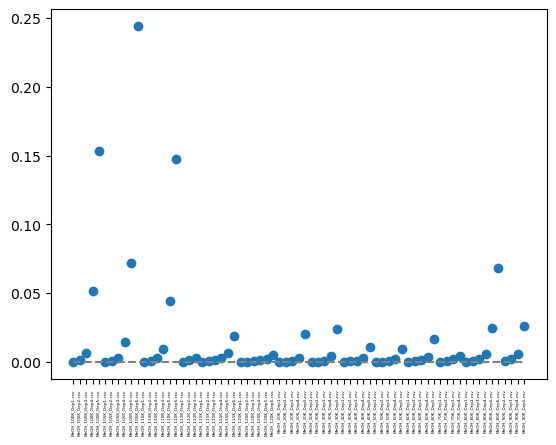

In [58]:

residuals_list = listdir(export_path)
residuals_list.sort()
os.chdir(export_path)

x_tags = ([])
y_tags = ([])

for residuals_list in residuals_list:
    df = pd.read_csv(residuals_list,header=[0])#,delimiter=r"\s+")
    to_show = df['residuals_sum'][0]
    x_tags = np.append(x_tags,residuals_list)
    y_tags = np.append(y_tags,to_show)
    
os.chdir('..')
os.chdir('..')

plt.plot(x_tags,y_tags, 'o')
plt.xticks(rotation=90, size=3)
plt.plot(x_tags, [0]*len(x_tags), color='gray', linestyle='--')
plt.show